# Package Comparison

*Martin Vonk - 2023*

This notebooks compares the calculated drought indices to other (Python) packages or time series retrieved from other locations.
Current comparisons include: 
* standard_precip (Python)
* climate_indices (Python)
* pastas (Python)
* SPEI (R)

Please note that it can be difficult to install these packages. SPEI (R) requires the R library. Pastas depends on Numba which has strict requirements for NumPy. Climate Indices only supports Python 3.11 and lower. Therefore running this notebook can be cumbersome.

Future comparisons:
* [KNMI](https://gitlab.com/KNMI-OSS/climexp/climexp_numerical/-/blob/be0f081a9d62856e4c52a370e70fec2ddfc45cfa/src/calcSPI3.f)

## Required packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

import spei as si

print(si.show_versions())

python: 3.11.13
spei: 0.8.0
numpy: 2.2.6
scipy: 1.16.1
matplotlib: 3.10.5
pandas: 2.3.1


## Read Precipitation Data

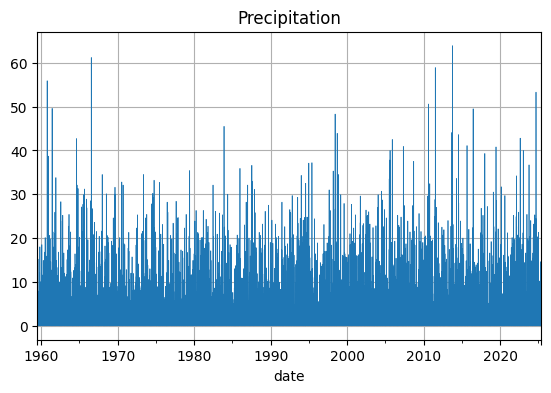

In [2]:
df = pd.read_csv("data/DEBILT.csv", index_col=0, parse_dates=True)
df.index.name = "date"
prec = df["Prec [m/d] 260_DEBILT"].multiply(1e3).rename("rain")
head = df["Head [m] B32C0572_DEBILT"].rename("B32C0572").dropna()

_ = prec.plot(grid=True, linewidth=0.5, title="Precipitation", figsize=(6.5, 4))

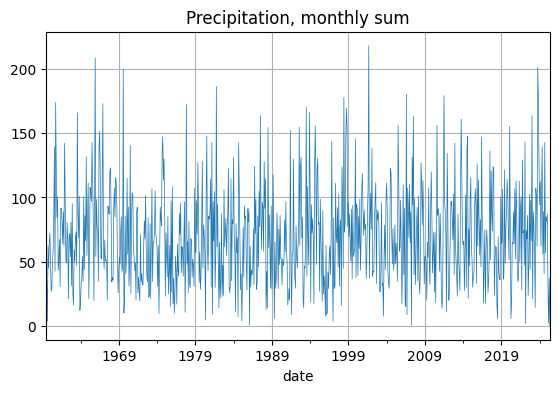

In [3]:
# get rolling sum
prec_rsum = prec.resample("ME").sum()
_ = prec_rsum.plot(
    grid=True, linewidth=0.5, title="Precipitation, monthly sum", figsize=(6.5, 4)
)

## Compute Standardized Precipitation Index

### Using SPEI package

In [4]:
spi = si.spi(prec_rsum, dist=scs.gamma, prob_zero=True, timescale=3, fit_freq="ME")
spi  # pandas Series

date
1959-09-30   -0.859224
1959-10-31   -1.897037
1959-11-30   -2.189269
1959-12-31   -1.000515
1960-01-31   -0.231999
                ...   
2025-01-31    0.272794
2025-02-28   -0.152606
2025-03-31   -1.156964
2025-04-30   -1.394517
2025-05-31   -2.469426
Freq: ME, Length: 789, dtype: float64

### Using standard_precip package

In [5]:
from standard_precip import spi as sp_spi

# standard_precip also needs rolling sum dataframe, even though you provide freq="M" and scale = 1
precdf = prec_rsum.to_frame().reset_index().copy()

# initialize spi
standardp_spi_inst = sp_spi.SPI()

# caclulate index with many parameters
standardp_spi = standardp_spi_inst.calculate(
    precdf,
    date_col="date",
    precip_cols="rain",
    freq="M",
    scale=3,  # note that scale is not the same for the standard deviation in SciPy
    fit_type="mle",
    dist_type="gam",
)
standardp_spi.index = standardp_spi.loc[
    :, "date"
].values  # create datetimeindex because date had to be a column

standardp_spi  # pandas DataFrame

,date,rain_scale_3,rain_scale_3_calculated_index
1959-07-31,1959-07-31,NaN,NaN
1959-08-31,1959-08-31,NaN,NaN
1959-09-30,1959-09-30,79.1,-1.977699
1959-10-31,1959-10-31,102.0,-1.953337
1959-11-30,1959-11-30,110.8,-2.189269
...,...,...,...
2025-01-31,2025-01-31,253.0,0.288813
2025-02-28,2025-02-28,201.2,-0.118100
2025-03-31,2025-03-31,121.8,-1.157576
2025-04-30,2025-04-30,72.2,-1.723688


### Using climate_indices package

Previously there was a significant difference beteween the SPEI and climate_indices package, not sure why. I thought it had something to do with the fitting method used for the gamma distribution. In issue [#61](https://github.com/martinvonk/SPEI/issues/61) it was mentioned that the same outcome could be achieved. However, I found it difficult to install `climate_indces` due to lack of support (for newer python versions).

In [6]:
# from climate_indices.compute import scale_values, Periodicity
# from climate_indices import compute, indices, utils

In [7]:
# initial_year = prec_rsum.index[0].year
# calibration_year_initial = prec_rsum.index[0].year
# calibration_year_final = prec_rsum.index[-1].year
# period_times = 366
# scale = 1
# periodicity = compute.Periodicity.daily

# values = prec_rsum.values

# scaled_values = compute.scale_values(
#     values,
#     scale=scale,
#     periodicity=periodicity,
# )

# alphas, betas = compute.gamma_parameters(
#     scaled_values,
#     data_start_year=initial_year,
#     calibration_start_year=calibration_year_initial,
#     calibration_end_year=calibration_year_final,
#     periodicity=periodicity,
# )

# gamma_params = {"alpha": alphas, "beta": betas}

# spival = indices.spi(
#     values,
#     scale=scale,
#     distribution=indices.Distribution.gamma,
#     data_start_year=initial_year,
#     calibration_year_initial=calibration_year_initial,
#     calibration_year_final=calibration_year_final,
#     periodicity=compute.Periodicity.daily,
#     fitting_params=gamma_params,
# )

# climateind_spi = pd.Series(spival, index=prec_rsum.index, name="Climate Index SPI")
# climateind_spi

### Using SPEI R package

In [8]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

sr = importr("SPEI")

with pandas2ri.converter.context():  # pandas2ri.activate()
    spir_res = sr.spi(prec_rsum.values, scale=3)

r_spi = pd.Series(spir_res[2].ravel(), index=prec_rsum.index, name="SPI")
r_spi

PackageNotInstalledError: The R package "SPEI" is not installed.

### Plot and compare

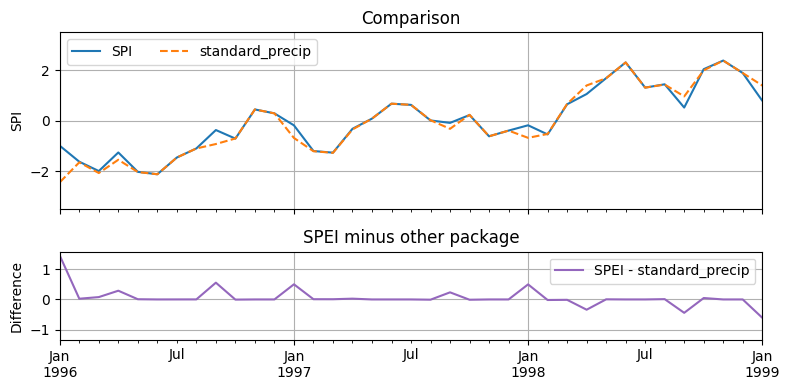

In [9]:
f, ax = plt.subplot_mosaic(
    [["SPI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
spi.plot(ax=ax["SPI"], grid=True, linestyle="-", label="SPI")
standardp_spi.iloc[:, -1].plot(
    ax=ax["SPI"],
    color="C1",
    grid=True,
    linestyle="--",
    label="standard_precip",
)
# climateind_spi.plot(
#     ax=ax["SPI"], color="C2", grid=True, linestyle=":", label="climate_indices"
# )
# r_spi.plot(ax=ax["SPI"], color="C2", grid=True, linestyle=":", label="R package")

(ax["SPI"].set_ylim(-3.5, 3.5),)
(ax["SPI"].set_title("Comparison"),)
(ax["SPI"].set_ylabel("SPI"),)
ax["SPI"].legend(ncol=3)

(spi - standardp_spi.iloc[:, -1]).plot(
    ax=ax["DIFF"], color="C4", label="SPEI - standard_precip", grid=True
)
# (spi - r_spi).plot(ax=ax["DIFF"], color="C3", label="SPEI - R Package")

# ax["DIFF1"].set_ylim(-0.05, 0.05)
ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()

Difference is very small between SPEI an the standard_precip package.

The standard_precip package does not explicitely support the Standardized Precipitation Evaporation Index, as far as I can see. However, the SPI class in standard_precip could probably be used, even though the naming of `precip_cols` is not universal. In general, the standard_precip package needs much more keyword arguments while the SPEI package makes more use of all the nice logic already available in SciPy and Pandas.

The climate_indices package needs even more code.

The SPEI R package also has a similar result but seems to vary a bit more. More research is needed to understand why that is the case. Most likely is the differences in fitting the gamma distribution.

## Compute Standardized Groundwater Index

In [10]:
import pastas as ps

sgi = si.sgi(head, fit_freq="ME")
sgi_pastas = ps.stats.sgi(head)

In [11]:
pd.concat([sgi, sgi_pastas], axis=1).rename(columns={0: "SGI", "head": "Pastas"})

,SGI,B32C0572
date,,
1968-12-13,0.510073,0.510073
1968-12-24,0.398855,0.398855
1969-01-14,0.220807,0.220807
1969-01-28,0.744936,0.744936
1969-02-14,0.650837,0.650837
...,...,...
2020-10-28,-0.052796,-0.052796
2020-11-15,-0.628006,-0.628006
2020-11-27,-0.510073,-0.510073


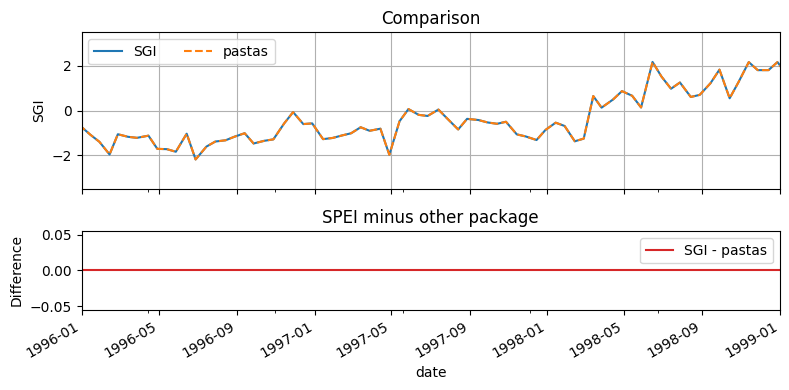

In [12]:
f, ax = plt.subplot_mosaic(
    [["SGI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
sgi.plot(ax=ax["SGI"], grid=True, linestyle="-", label="SGI")
sgi_pastas.plot(ax=ax["SGI"], color="C1", grid=True, linestyle="--", label="pastas")
(ax["SGI"].set_ylim(-3.5, 3.5),)
(ax["SGI"].set_title("Comparison"),)
(ax["SGI"].set_ylabel("SGI"),)
ax["SGI"].legend(ncol=3)

(sgi - sgi_pastas).plot(ax=ax["DIFF"], color="C3", label="SGI - pastas")

ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()